# Collaborative Filtering - Matrix factorization
This script takes user and movie ratings as input to predict a user's rating of another movie, and thus recommend it.

In [1]:
#!pip install torchtext
#!pip install torch

In [2]:
#### Packages ####
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from scipy.sparse import rand as sprand
from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms, utils
from torch.utils import data
from torchtext.data import Dataset, BucketIterator, Field, TabularDataset, Iterator

from torchtext import datasets
import math

%matplotlib inline

import sklearn 
from sklearn.metrics import accuracy_score
import matplotlib
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from torchtext import data
from torchtext import datasets
from torch.autograd import Variable
from torch.nn import Linear, RNN, LSTM

# we'll use the bokeh library to create beautiful plots
# *_notebook functions are needed for correct use in jupyter
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook, show, push_notebook
output_notebook()

Loading BokehJS ...

In [3]:
#### Activating cuda for speeding up training ####
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

Device in use: cpu


In [4]:
#### Loading dataset ####
# We are only interested in user ID, movie ID and ratings
ratings_df = pd.read_csv('ratings_small.csv', usecols = ['userId','movieId','rating'])

In [5]:
#### Creating new indices ####
def zero_indexing(column):
    uniq = column.unique()
    newindex = {o:i for i,o in enumerate(uniq)}
    # Subtracting 1 from the original ID's
    return newindex, np.array([newindex.get(x, -1) for x in column])

_,usercol = zero_indexing(ratings_df["userId"])
_,moviecol = zero_indexing(ratings_df["movieId"])

ratings_df["userId"] = usercol
ratings_df["movieId"] = moviecol

# Removing ID's which are less than 0
ratings_dataset = ratings_df[ratings_df["userId"] >= 0]
ratings_dataset = ratings_df[ratings_df["movieId"] >= 0]

print("Printing head of dataset with new IDs: ")
print(ratings_dataset.head())

Printing head of dataset with new IDs: 
   userId  movieId  rating
0       0        0     2.5
1       0        1     3.0
2       0        2     3.0
3       0        3     2.0
4       0        4     4.0


In [6]:
#### Splitting dataset into training, validation and test sets ####
n = len(ratings_dataset)
sizes = [0.7, 0.2, 0.1]
train_size = int(sizes[0]*n)
val_size = int(sizes[1]*n)
test_size = int(sizes[2]*n)

train_set = ratings_dataset[:train_size-1].copy() # till 70002-1 = 70001
val_set = ratings_dataset[train_size:-test_size-1].copy() # from 70002 to 100.004 - 20000
test_set = ratings_dataset[train_size+val_size:].copy() # from train+val size

print("Entire dataset: ", n)
print("Train size: ", train_set.shape[0])
print("Validation size: ", val_set.shape[0])
print("Test size: ", test_set.shape[0])
print("Checking if dimensions match: ", train_set.shape[0] + val_set.shape[0] + test_set.shape[0] == n )

Entire dataset:  100004
Train size:  70001
Validation size:  20001
Test size:  10002
Checking if dimensions match:  True


In [7]:
#### Creating a dataformatting to format the data ####
class dataformatting(Dataset):
    def __init__(self, users, movies, rating):
        self.movies = movies
        self.users = users
        self.rating = rating
        
    def __len__(self):
        return len(self.rating)

    def __getitem__(self, index):
        u = self.users[index]
        m = self.movies[index]
        r = self.rating[index]
        #obs = {'movieId':movieId,'userId':userId,'rating':rating}
        #obs = self.movieLens.drop('timestamp',axis=1)
        #obs = obs.iloc[index,:].as_matrix()
        return [u, m, r]

In [8]:
#### Formatting training, validation and training sets ####
u_train = torch.LongTensor(train_set.userId.values)
m_train = torch.LongTensor(train_set.movieId.values)
r_train = torch.FloatTensor(train_set.rating.values)

train_dataset = dataformatting(u_train, m_train, r_train)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

u_val = torch.LongTensor(val_set.userId.values)
m_val = torch.LongTensor(val_set.movieId.values)
r_val = torch.FloatTensor(val_set.rating.values)
val_dataset = dataformatting(u_val, m_val,r_val)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=True)

u_test = torch.LongTensor(test_set.userId.values)
m_test = torch.LongTensor(test_set.movieId.values)
r_test = torch.FloatTensor(test_set.rating.values)
test_dataset = dataformatting(u_test, m_test, r_test)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True)

In [9]:
num_user = len(ratings_dataset.userId.unique()) 
num_movie = len(ratings_dataset.movieId.unique())

class MatrixFactorization(nn.Module):
    def __init__(self, num_user, num_movie):
        super(MatrixFactorization, self).__init__()
        emb_size=100
        self.user_embedding = nn.Embedding(num_user, emb_size)
        self.movie_embedding = nn.Embedding(num_movie, emb_size)
        
    def forward(self, u, m):
        U = self.user_embedding(u)
        M = self.movie_embedding(m)
        r_max = 5 # maximum rating
        r_min = 1 # minimum rating
        res = F.sigmoid((U*M).sum(1))*(r_max - r_min) + r_min
        #print("Computed rating: ", res)
        return res

In [10]:
## Training loop
def train(model, train_iter, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_iter):
        users, items, ratings = data
        batch_size = len(users)
        users = users.long()
        items = items.long()
        ratings = ratings.float()      
        ratings = ratings.view(-1)
        optimizer.zero_grad()
        
        output = model(users, items)
        output = output.view(-1)
        loss = criterion(output.float(), ratings)
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item()
        
        return train_loss/len(train_iter)

def validate(model, val_iter, criterion, epoch):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(val_iter):
            users, items, ratings = data
            batch_size = len(users)
            users = users.long()
            items = items.long()
            ratings = ratings.float()
            ratings = ratings.view(-1)
            
            #ratings = ratings.unsqueeze(1)
            output = model(users, items)
            loss = criterion(output.float(), ratings)
            val_loss+=loss.item()
    return val_loss/len(val_iter)

def trainLoop(epochs, lr=0.001, wd = 1e-6):
    # Defining model    
    model = MatrixFactorization(num_user, num_movie)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay = wd)
    accstrain = []
    lossestrain = []
    
    accsval = []
    lossesval = []

    best_acc = (-1.000005,-1e16,1e16)
    best_loss = (-1.00005,-1e16,1e16)
    
    for epoch in range(1, epochs + 1):
        train_loss = train(model, train_iter, optimizer, criterion, epoch)
        val_loss = validate(model, val_iter, criterion, epoch)
        
        lossestrain += [train_loss]
        lossesval += [val_loss]
       # print(f'Epoch {epoch}: Train average loss: {lossestrain:.2f} | Validation average loss: {lossesval:.2f}')

    #### plots ####
    plt.figure()   
    plt.plot(range(1,epoch+1),lossestrain, 'r', range(1,epoch+1),lossesval, 'b')
    #print(f'Best validation accuracy epoch: {best_acc[0]:>3.0f}, accuracy: {best_acc[1]:>2.5f}, mean loss: {best_acc[2]:>2.5f} \n')
    plt.legend(['Training loss','Validation loss'])
    plt.xlabel('Epochs'), plt.ylabel('Loss')
    
    return model

MatrixFactorization(
  (user_embedding): Embedding(671, 100)
  (movie_embedding): Embedding(9066, 100)
)

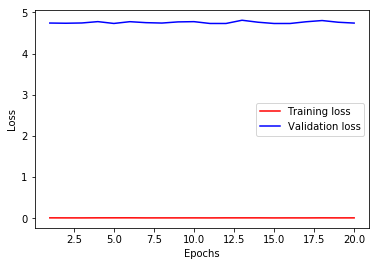

In [12]:
trainLoop(epochs=20, lr=0.0001, wd=1e-5)